In [ ]:
# -*- coding: utf-8 -*-
#  File: otus_adv_hw1_automl_atom.ipynb
#  Project: 'OTUS.ADV Homework #1'
#  Created by Gennady Matveev (gm@og.ly) on 06-01-2022.

# **$Homework$** **$1$**  
**OTUS Machine Learning Advanced**

### AutoML

![AutoML](https://docs.google.com/uc?export=download&id=1b93cmYN0YTyizsbhgUcjRfdXK7mqG4k9)

Goals:   
- AutoML: try out automatic feature generation/selection and modelling 
- Compare AutoML performance in ATOM library with baseline
and any two out of the box models

Means:  
- All meaningful programming will be done in ATOM  
    https://tvdboom.github.io/ATOM/about/

Dataset:
- Richter's Predictor: Modeling Earthquake Damage  
https://www.drivendata.org/competitions/57/nepal-earthquake/data/

#### ATOM library provides convenient wrappers for TPOT and DFS/GFG feature generation methods along with several feature selection approaches, including RFECV.

Abbreviations:
- BO: bayesian optimization
- DFS: deep feature synthesis
- BA: balanced accuracy
- FE: feature engineering
- H/P: hyperparameters
- OOB: out of the box
- RFECV: recursive feature elimination with cross-validation

### Choice of models
- AutoML is represented by atom.automl class, a wrapper on TPOT in ATOM library  
- Logistic Regressor will serve as a baseline model  
- Logistic Regression (baseline) and Random Forest and LightGBM classifiers will compete with AutoML solution

Methodology:
- DFS/RFECV will be used for AutoML only.  
- OOB H/P will be tuned with BO primarily to get some CV statistics.  
- Weighted F1 score will be used as the main performance metrics following  suggestion of the  
competition organizers.  

<a href="https://colab.research.google.com/github/oort77/OTUS_ADV_HW1/blob/main/notebooks/otus_adv_hw1_automl_atom.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

### Google colab specific part

Typical runtime on Colab is several hours unless you set **max_time_mins** of atom.automl in **_Create AutoML model with DFS_** section to lower value.  

Note that this notebook runs on 20% of data by default. This can be changed in **_Take part of data_** section: either change rand_part value to set a desired percentage of data to use or set partial = 0 to run on full data.

Please uncomment below to install the notebook dependencies.

Dependencies installation requires restart of runtime.

In [ ]:
# !pip install -r 'https://drive.google.com/uc?export=download&id=1VmHDlGXo1IMHZ2kAT5IW4r4suWAfmiXs'

### Import libraries and setup notebook

In [ ]:
import os
import pandas as pd
import numpy as np
from atom import ATOMClassifier #, ATOMLoader
from sklearn.preprocessing import StandardScaler, \
                    RobustScaler, FunctionTransformer

import matplotlib.pyplot as plt
import seaborn as sns

import gdown
import random
import shutil
import warnings
from IPython.core.display import display, HTML

pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.


#### Miscellaneius settings 

In [ ]:
%matplotlib inline
display(HTML("<style>.container { width:80% !important; }</style>"))
%config InlineBackend.figure_format = 'retina'
plt.rcParams['figure.figsize']=(10,5)
sns.set(rc = {'figure.figsize':(8,5)})
warnings.filterwarnings("ignore")
pd.options.display.precision = 4

#### ML parameters

In [ ]:
random_state = 17
n_jobs = -1 # Try 2 on Colab
models = ["LR0", "RF0", "LGB0"] 
metric = ["F1_weighted", "logloss", "BA", "precision_weighted"]

#### Parameters of BO

In [ ]:
n_calls = 32
n_initial_points = 32

#### Parameters of DFS and RFECV

In [ ]:
n_features_dfs = 64
n_features_rfecv = 32

#### Helper function

In [ ]:
def nice_metric_table(df: pd.DataFrame, metric: list) -> pd.DataFrame:
    df1 = pd.DataFrame()
    for col in df.columns:
        if col.startswith("time"):
            df.drop(columns=col, inplace=True)
    for c in df.columns:
        df1 = pd.concat([df1, pd.DataFrame([pd.Series(x)
                        for x in df[c]])], axis=1)
    cols = [(init, metr) for init in df.columns for metr in metric]
    df1.columns = pd.MultiIndex.from_tuples(cols)
    df1.index = df.index
    return df1

### Load data

In [ ]:
# Download data from Google Drive
if os.path.isdir("../data") == False:
    !mkdir ../data

url = "https://drive.google.com/uc?export=download&id=1Z2PeT1anXzFc49yukOQhJbKi0HNfz2wd"
gdown.download(url, output="../data/Archive.zip")
shutil.unpack_archive("../data/Archive.zip", "../data")

X = pd.read_csv('../data/train_values.csv',index_col=0)
y = pd.read_csv('../data/train_labels.csv',index_col=0)
df = X.join(y)
df.head()

Downloading...
From: https://drive.google.com/uc?export=download&id=1Z2PeT1anXzFc49yukOQhJbKi0HNfz2wd
To: /home/gm/notebooks/OTUS/OTUS.ML_ADV/HW1/data/Archive.zip
100%|██████████| 7.25M/7.25M [00:00<00:00, 42.3MB/s]


,geo_level_1_id,geo_level_2_id,geo_level_3_id,count_floors_pre_eq,age,area_percentage,height_percentage,land_surface_condition,foundation_type,roof_type,...,has_secondary_use_hotel,has_secondary_use_rental,has_secondary_use_institution,has_secondary_use_school,has_secondary_use_industry,has_secondary_use_health_post,has_secondary_use_gov_office,has_secondary_use_use_police,has_secondary_use_other,damage_grade
building_id,,,,,,,,,,,,,,,,,,,,,
802906,6,487,12198,2,30,6,5,t,r,n,...,0,0,0,0,0,0,0,0,0,3
28830,8,900,2812,2,10,8,7,o,r,n,...,0,0,0,0,0,0,0,0,0,2
94947,21,363,8973,2,10,5,5,t,r,n,...,0,0,0,0,0,0,0,0,0,3
590882,22,418,10694,2,10,6,5,t,r,n,...,0,0,0,0,0,0,0,0,0,2
201944,11,131,1488,3,30,8,9,t,r,n,...,0,0,0,0,0,0,0,0,0,3


### Take part of data

In [ ]:
rand_part = 0.2 # for testing of computationally expensive parts
partial = 1 # for rapid tests set to 1 and possibly change rand_part ratio above

# Randomly select rand_part of rows
part = sorted(random.choices(range(df.shape[0]), k=int(df.shape[0]*rand_part)))
if partial == 0:
    X, y = df.iloc[:,:-1], df.iloc[:,-1]
else:
    X, y = df.iloc[part,:-1], df.iloc[part,-1]
# df.shape
X.shape, y.shape

((52120, 38), (52120,))

### Instantiate ATOM

In [ ]:
atom = ATOMClassifier(X, y, test_size=0.25, n_jobs=n_jobs, 
                      verbose=1, warnings=False, random_state=random_state)
atom.title_fontsize = 17

<< ================== ATOM ================== >>
Algorithm task: multiclass classification.
Parallel processing with 8 cores.

Dataset stats ==================== >>
Shape: (62402, 39)
Scaled: False
Categorical features: 8 (21.1%)
Outlier values: 28323 (1.6%)
Duplicate samples: 15641 (25.1%)
-------------------------------------
Train set size: 46802
Test set size: 15600
-------------------------------------



### Preprocessing (minimal)

In [ ]:
atom.impute()
atom.clean(drop_min_cardinality=False)
atom.encode()
# atom.add(StandardScaler())
atom.add(RobustScaler())
# atom.gauss()

Fitting Imputer...
Imputing missing values...
Applying data cleaning...
Fitting Encoder...
Encoding categorical columns...
Fitting RobustScaler...
Applying RobustScaler to the dataset...


### Baseline model - LogisticRegression  
### OOB models - RandomForest and LightGBM

To put comptitors on the level ground, we will apply Bayesian H/P optimization to OOB models

In [ ]:
atom.branch = "baseline_and_oob"
# Fit the models to the data with Bayesian optimisation
atom.run(
    models=models,
    metric=metric,
    n_calls=n_calls,
    n_initial_points=n_initial_points,
    n_bootstrap=5
)

New branch baseline_and_oob successfully created.

Training ========================= >>
Models: LR0, RF0, LGB0
Metric: f1_weighted, neg_log_loss, balanced_accuracy, precision_weighted


Running BO for Logistic Regression...


Initial point 32: 100%|██████████| 32/32 [17:18<00:00, 32.46s/it] 


Bayesian Optimization ---------------------------
Best call --> Initial point 8
Best parameters --> {'penalty': 'l2', 'C': 10.5817, 'solver': 'newton-cg', 'max_iter': 967}
Best evaluation --> f1_weighted: 0.5413   neg_log_loss: -0.7964   balanced_accuracy: 0.4625   precision_weighted: 0.5756
Time elapsed: 17m:19s
Fit ---------------------------------------------
Train evaluation --> f1_weighted: 0.5376   neg_log_loss: -0.7928   balanced_accuracy: 0.4603   precision_weighted: 0.5721
Test evaluation --> f1_weighted: 0.5474   neg_log_loss: -0.7917   balanced_accuracy: 0.4653   precision_weighted: 0.5818
Time elapsed: 24.258s
Bootstrap ---------------------------------------
Evaluation --> f1_weighted: 0.5485 ± 0.0007   neg_log_loss: -0.7931 ± 0.0007   balanced_accuracy: 0.4663 ± 0.0037   precision_weighted: 0.5807 ± 0.0031
Time elapsed: 1m:51s
-------------------------------------------------
Total time: 19m:34s


Running BO for Random Forest...


Initial point 32: 100%|██████████| 32/32 [01:28<00:00,  2.76s/it]


Bayesian Optimization ---------------------------
Best call --> Initial point 7
Best parameters --> {'n_estimators': 177, 'criterion': 'entropy', 'max_depth': 8, 'min_samples_split': 2, 'min_samples_leaf': 8, 'max_features': 0.8, 'bootstrap': False, 'ccp_alpha': 0.0021}
Best evaluation --> f1_weighted: 0.6216   neg_log_loss: -0.7198   balanced_accuracy: 0.5261   precision_weighted: 0.6546
Time elapsed: 1m:28s
Fit ---------------------------------------------
Train evaluation --> f1_weighted: 0.6235   neg_log_loss: -0.7212   balanced_accuracy: 0.5236   precision_weighted: 0.6574
Test evaluation --> f1_weighted: 0.6351   neg_log_loss: -0.7152   balanced_accuracy: 0.5286   precision_weighted: 0.667
Time elapsed: 5.371s
Bootstrap ---------------------------------------
Evaluation --> f1_weighted: 0.6353 ± 0.0021   neg_log_loss: -0.7135 ± 0.0006   balanced_accuracy: 0.5361 ± 0.0069   precision_weighted: 0.6682 ± 0.002
Time elapsed: 25.674s
-------------------------------------------------
T

Initial point 32: 100%|██████████| 32/32 [01:08<00:00,  2.15s/it]


Bayesian Optimization ---------------------------
Best call --> Initial point 24
Best parameters --> {'n_estimators': 463, 'learning_rate': 0.8644, 'max_depth': 5, 'num_leaves': 40, 'min_child_weight': 0.1, 'min_child_samples': 11, 'subsample': 0.7, 'colsample_bytree': 0.9, 'reg_alpha': 1, 'reg_lambda': 0}
Best evaluation --> f1_weighted: 0.7725   neg_log_loss: -0.654   balanced_accuracy: 0.7305   precision_weighted: 0.7725
Time elapsed: 1m:09s
Fit ---------------------------------------------
Train evaluation --> f1_weighted: 0.9647   neg_log_loss: -0.1543   balanced_accuracy: 0.9657   precision_weighted: 0.9648
Test evaluation --> f1_weighted: 0.7892   neg_log_loss: -0.5877   balanced_accuracy: 0.7481   precision_weighted: 0.7891
Time elapsed: 4.097s
Bootstrap ---------------------------------------
Evaluation --> f1_weighted: 0.7693 ± 0.0032   neg_log_loss: -0.7045 ± 0.0108   balanced_accuracy: 0.7228 ± 0.003   precision_weighted: 0.7691 ± 0.0033
Time elapsed: 12.884s
--------------

In [ ]:
atom.branch.status()

Branch: baseline_and_oob
 --> Pipeline: 
   >>> Imputer
     --> strat_num: drop
     --> strat_cat: drop
     --> max_nan_rows: None
     --> max_nan_cols: None
   >>> Cleaner
     --> drop_types: None
     --> strip_categorical: True
     --> drop_max_cardinality: True
     --> drop_min_cardinality: False
     --> drop_duplicates: False
     --> drop_missing_target: True
     --> encode_target: True
   >>> Encoder
     --> strategy: LeaveOneOut
     --> max_onehot: 10
     --> ordinal: None
     --> frac_to_other: None
     --> kwargs: {}
   >>> RobustScaler
     --> with_centering: True
     --> with_scaling: True
     --> quantile_range: (25.0, 75.0)
     --> copy: True
     --> unit_variance: False
 --> Models: LR0, RF0, LGB0


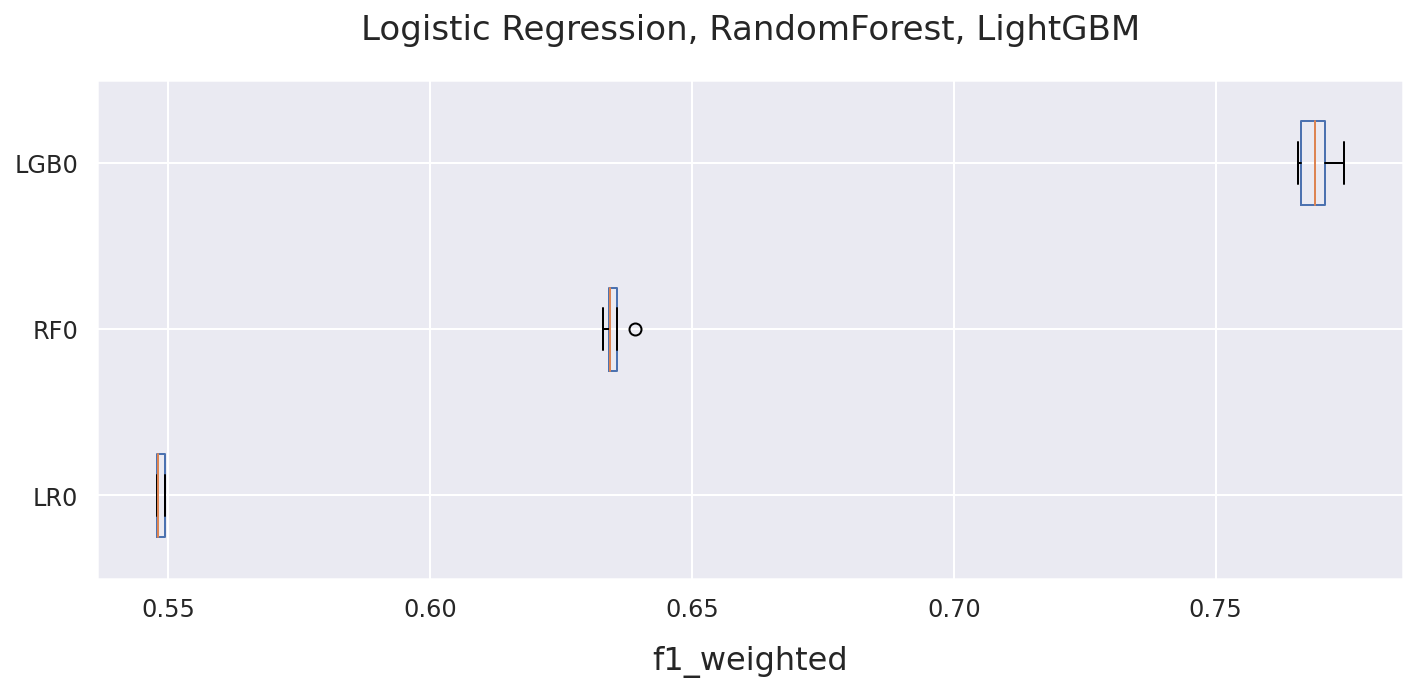

In [ ]:
atom.plot_results(title="Logistic Regression, RandomForest, LightGBM", figsize=(10,5))

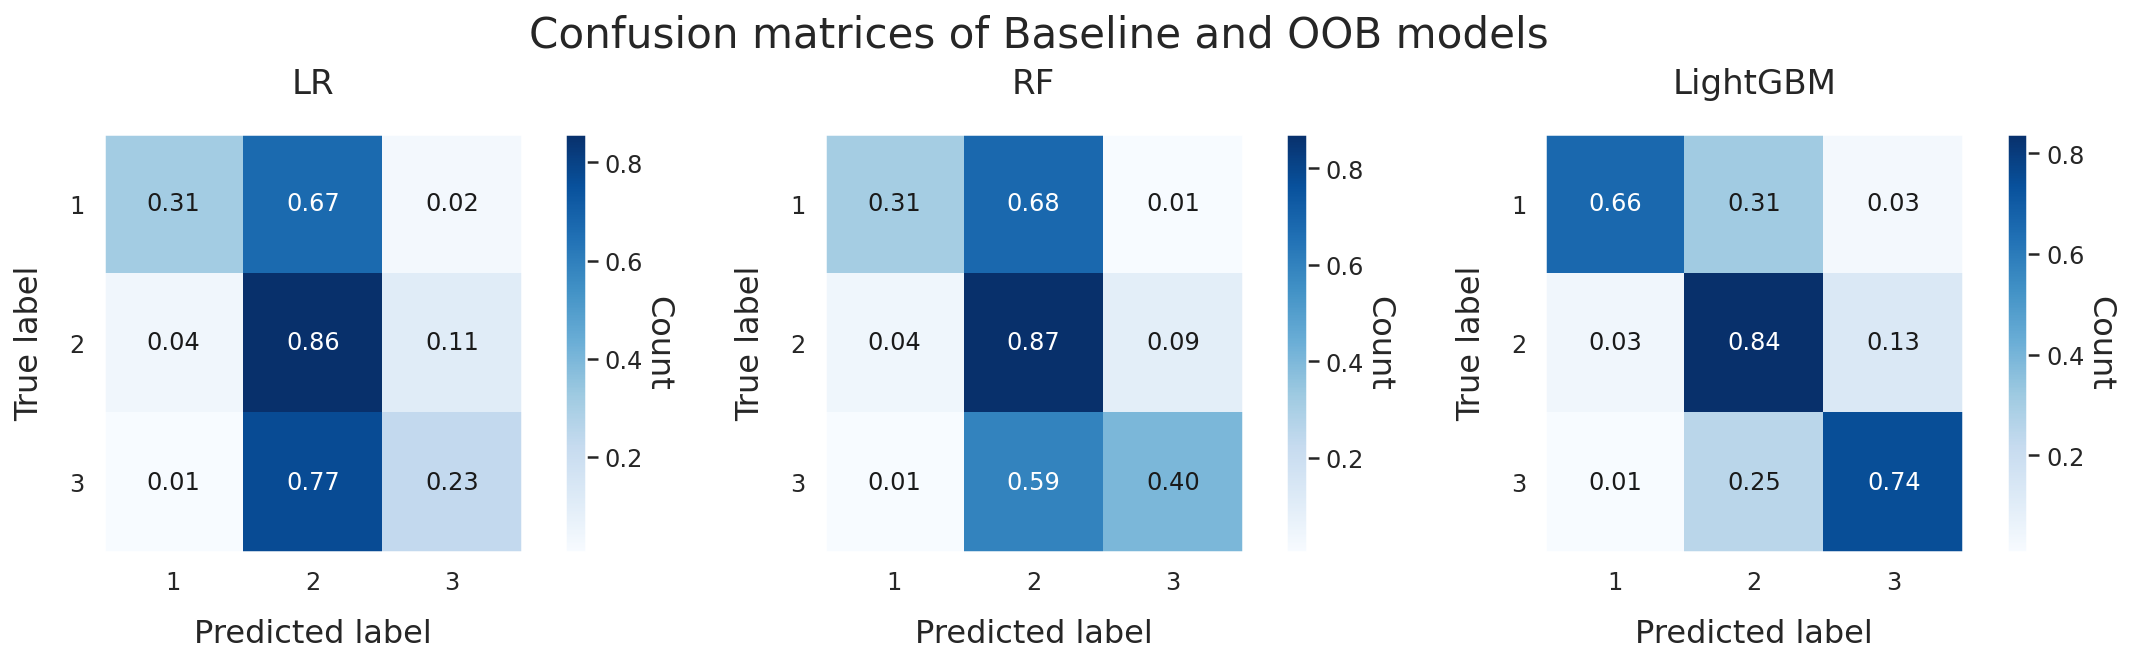

In [ ]:
with atom.canvas(1, 3, title="Confusion matrices of Baseline and OOB models", figsize =(15,4.5)):
    atom.lr0.plot_confusion_matrix(dataset="test", normalize=True, title=f"LR") 
    atom.rf0.plot_confusion_matrix(dataset="test", normalize=True, title=f"RF")
    atom.lgb0.plot_confusion_matrix(dataset="test", normalize=True, title=f"LightGBM")

In [ ]:
nice_metric_table(atom.results, metric=metric).style.highlight_max(props='color:orange', axis=0)

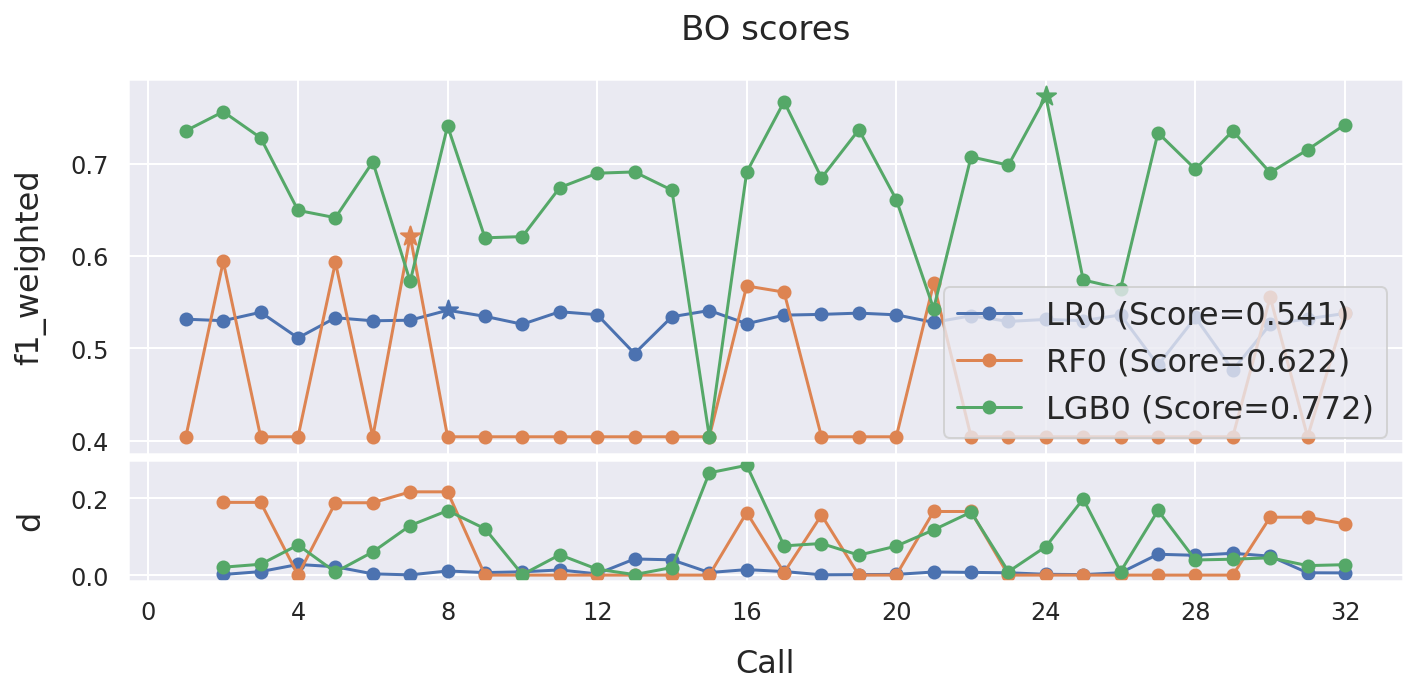

In [ ]:
atom.plot_bo(title="BO scores", figsize=(10,5))

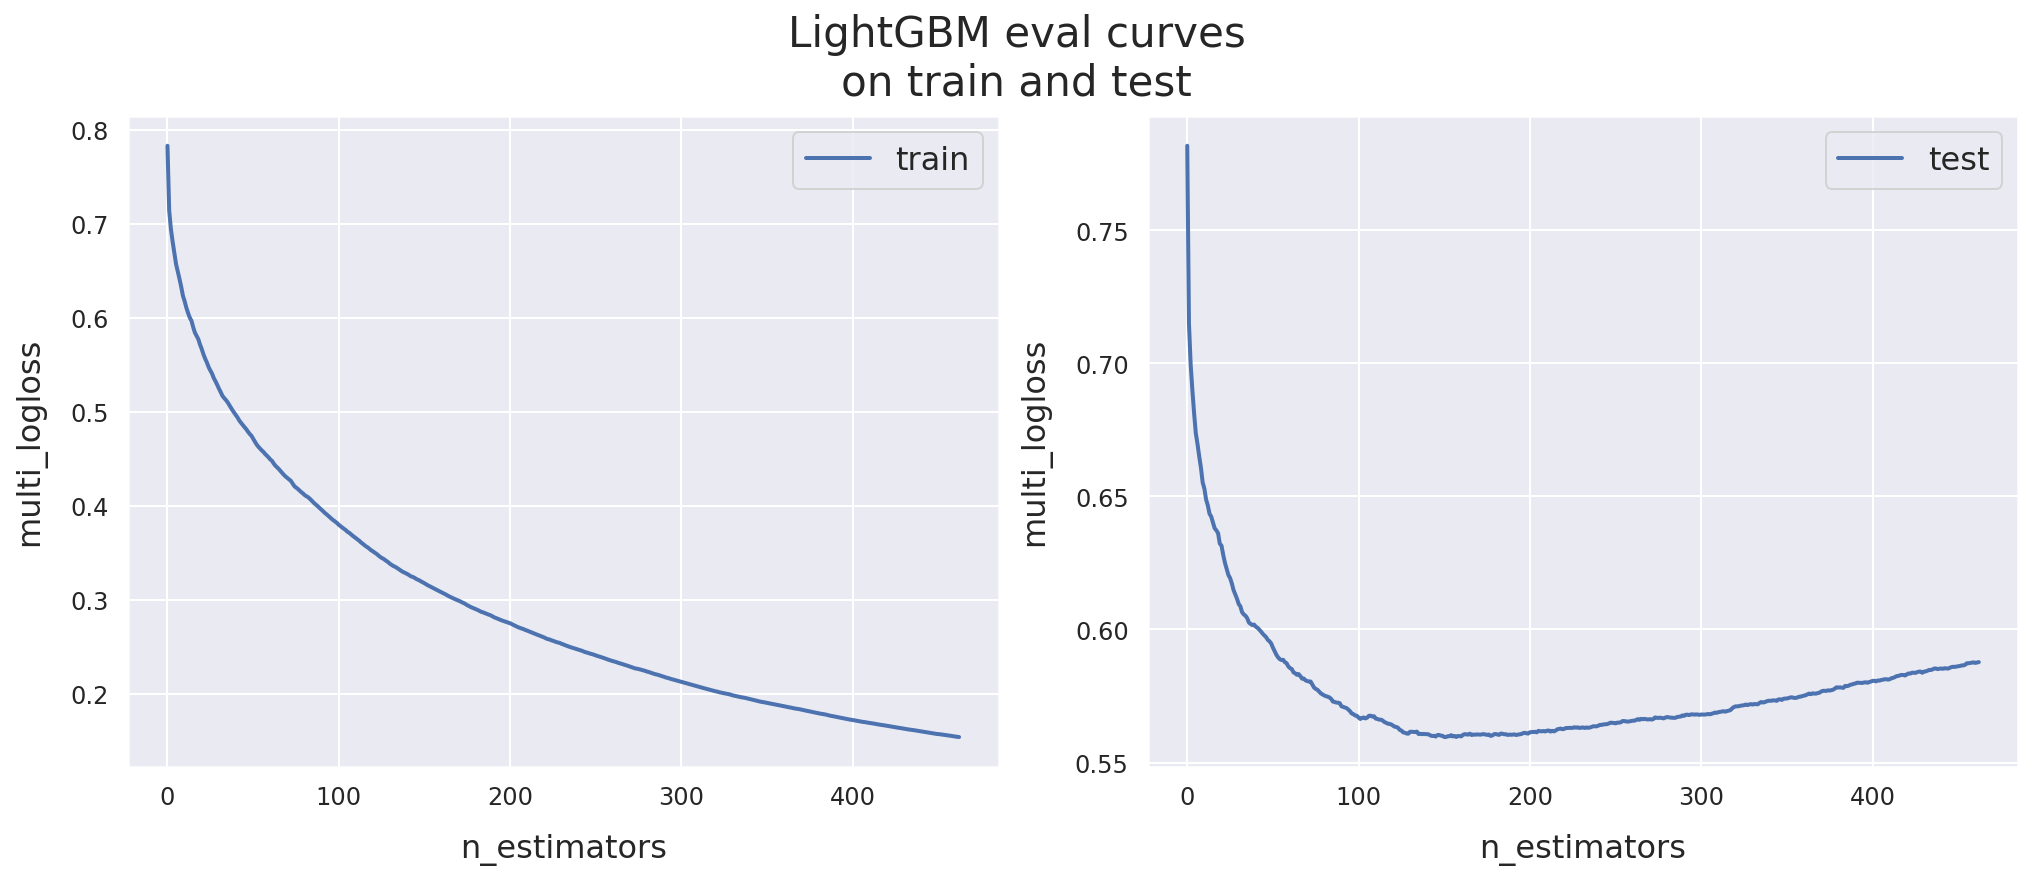

In [ ]:
with atom.canvas(1, 2, title="LightGBM evaluation curves\non train and test"):    
    atom.lgb0.plot_evals(dataset="train", figsize=(5,5))
    atom.lgb0.plot_evals(dataset="test", figsize=(5,5))

### Feature engineering for AutoML

#### Run DFS

In [ ]:
atom.verbose = 2
atom.branch = "auto_from_master"
atom.feature_generation("dfs", 
                        n_features=n_features_dfs, 
                        operators=["add", "sub", "mul"], #, "div"
                        n_jobs = n_jobs,
                        verbose=0,
                        random_state=random_state)

New branch auto successfully created.
Creating new features...
EntitySet scattered to 8 workers in 3 seconds
 --> 132 new features were added to the dataset.


#### Make post-DFS feature selection

In [ ]:
atom.feature_selection(
    strategy="RFECV",
    solver="RF",
    n_features=n_features_rfecv,
    scoring="F1_weighted",
    max_correlation=0.98,
    random_state=random_state,
    n_jobs=n_jobs
)

Fitting FeatureSelector...
Performing feature selection ...
 --> Feature ground_floor_type_x * has_secondary_use_use_police was removed due to low variance. Value 0.0 repeated in 100% of the rows.
 --> Feature has_secondary_use_gov_office * position_j was removed due to low variance. Value 0.0 repeated in 100% of the rows.
 --> Feature has_secondary_use_rental * plan_configuration_n was removed due to low variance. Value 0.0 repeated in 100% of the rows.
 --> Feature has_secondary_use_school * plan_configuration_c was removed due to low variance. Value 0.0 repeated in 100% of the rows.
 --> Feature plan_configuration_f * position_o was removed due to low variance. Value 0.0 repeated in 100% of the rows.
 --> Feature plan_configuration_f * roof_type_x was removed due to low variance. Value 0.0 repeated in 100% of the rows.
 --> Feature plan_configuration_m * position_t was removed due to low variance. Value 0.0 repeated in 100% of the rows.
 --> Feature age - ground_floor_type_m was rem

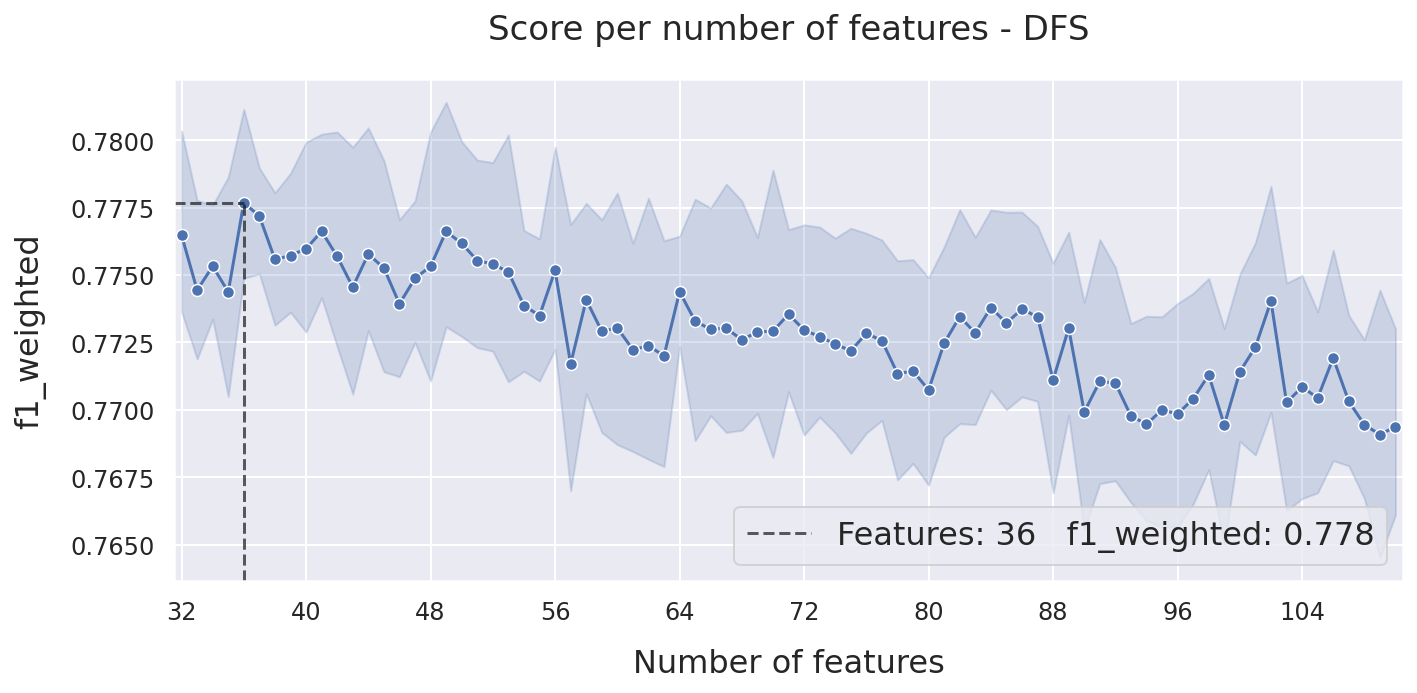

In [ ]:
atom.plot_rfecv(title="Score per number of features - DFS", figsize=(10,5))

Dataset with new DFS features

In [ ]:
atom.X.head()

,geo_level_1_id,geo_level_2_id,geo_level_3_id,count_floors_pre_eq,age,area_percentage,height_percentage,foundation_type_r,roof_type_n,ground_floor_type_f,...,has_superstructure_other - other_floor_type_x,has_superstructure_other - roof_type_n,has_superstructure_rc_non_engineered - other_floor_type_j,has_superstructure_timber - legal_ownership_status_a,has_superstructure_timber - plan_configuration_q,height_percentage * land_surface_condition_t,land_surface_condition_n - position_s,land_surface_condition_n - roof_type_x,land_surface_condition_t - roof_type_x,legal_ownership_status_v + position_s
0,-0.1429,-0.0656,-0.9270,0.0,-0.50,0.25,1.0,-1.0,-1.0,-1.0,...,0.0,1.0,0.0,0.0,0.0,0.0,0.0,-1.0,-1.0,0.0
1,-0.3571,-0.1098,0.4682,-1.0,-0.75,-1.25,-1.5,0.0,0.0,0.0,...,0.0,0.0,-1.0,1.0,1.0,-0.0,0.0,0.0,0.0,0.0
2,0.2857,-0.5093,-0.9631,0.0,0.75,0.25,0.0,0.0,0.0,-1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.3571,-0.4394,0.8820,1.0,-0.25,-0.25,1.0,0.0,0.0,0.0,...,-1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,-0.5714,-0.1940,0.0973,0.0,0.00,0.50,-0.5,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,-0.0,1.0,0.0,0.0,-1.0


In [ ]:
atom.X.shape

(62402, 36)

In [ ]:
# The collinear attribute shows what features were removed due to multicollinearity
atom.collinear

,drop_feature,correlated_feature,correlation_value
0,age - ground_floor_type_m,age,0.99992
1,count_floors_pre_eq + ground_floor_type_z,count_floors_pre_eq,0.99648
2,foundation_type_i - plan_configuration_c,foundation_type_i,0.98632
3,ground_floor_type_f + has_secondary_use_instit...,ground_floor_type_f,0.99699
4,ground_floor_type_m + roof_type_q,roof_type_q,0.99362
5,ground_floor_type_x + has_secondary_use_gov_of...,ground_floor_type_x,0.99962
6,ground_floor_type_z - plan_configuration_f,ground_floor_type_z,0.99146
7,has_secondary_use - plan_configuration_n,has_secondary_use,0.99934
8,has_secondary_use_agriculture - plan_configura...,has_secondary_use_agriculture,0.98967
9,has_secondary_use_gov_office + plan_configurat...,plan_configuration_q,0.99846


In [ ]:
print(f"New dataset has {atom.X.shape[1]} features")

New dataset has 36 features


### Create AutoML model with DFS

In [ ]:
# atom.branch = "auto_ml"

In [ ]:
atom.verbose=2
atom.automl(
            max_time_mins=360,
            template="Transformer-Transformer-Classifier",
            early_stop = 2,
            cv=5,
            n_jobs=n_jobs,
            random_state = random_state
)

Fitting automl algorithm...


Optimization Progress:   0%|          | 0/100 [00:00<?, ?pipeline/s]


Generation 1 - Current best internal CV score: 0.7602162582761428

Generation 2 - Current best internal CV score: 0.7602162582761428

Generation 3 - Current best internal CV score: 0.7697219185030832

Generation 4 - Current best internal CV score: 0.7697219185030832

Generation 5 - Current best internal CV score: 0.7827749160239261

Generation 6 - Current best internal CV score: 0.7827749160239261

Generation 7 - Current best internal CV score: 0.7827749160239261

The optimized pipeline was not improved after evaluating 2 more generations. Will end the optimization process.

TPOT closed prematurely. Will use the current best pipeline.

Best pipeline: RandomForestClassifier(ZeroCount(MaxAbsScaler(input_matrix)), bootstrap=False, criterion=entropy, max_features=0.45, min_samples_leaf=4, min_samples_split=7, n_estimators=100)

Merging automl results with atom...
Applying MaxAbsScaler to the dataset...
Fitting ZeroCount...
Applying ZeroCount to the dataset...
Adding model Random Forest (R

### Final model

#### TPOT configuration

In [ ]:
atom.tpot

TPOTClassifier(early_stop=2, max_time_mins=360, n_jobs=-1, random_state=17,
               scoring=make_scorer(f1_score, pos_label=None, average=weighted),
               template='Transformer-Transformer-Classifier', verbosity=2)

In [ ]:
atom.tpot.get_params()

{'config_dict': None,
 'crossover_rate': 0.1,
 'cv': 5,
 'disable_update_check': False,
 'early_stop': 2,
 'generations': 100,
 'log_file': None,
 'max_eval_time_mins': 5,
 'max_time_mins': 360,
 'memory': None,
 'mutation_rate': 0.9,
 'n_jobs': -1,
 'offspring_size': None,
 'periodic_checkpoint_folder': None,
 'population_size': 100,
 'random_state': 17,
 'scoring': make_scorer(f1_score, pos_label=None, average=weighted),
 'subsample': 1.0,
 'template': 'Transformer-Transformer-Classifier',
 'use_dask': False,
 'verbosity': 2,
 'warm_start': False}

#### Best Pipeline

In [ ]:
atom.winner

Random Forest
 --> Estimator: RandomForestClassifier
 --> Evaluation: f1_weighted: 0.7979   neg_log_loss: -0.4946   balanced_accuracy: 0.7351   precision_weighted: 0.8009

#### Resulting pipeline

In [ ]:
atom.tpot.fitted_pipeline_

Pipeline(steps=[('maxabsscaler', MaxAbsScaler()), ('zerocount', ZeroCount()),
                ('randomforestclassifier',
                 RandomForestClassifier(bootstrap=False, criterion='entropy',
                                        max_features=0.45, min_samples_leaf=4,
                                        min_samples_split=7,
                                        random_state=17))])

####  Export pipeline to sklearn format

In [ ]:
pl = atom.export_pipeline(model="rf")
print(pl)

Pipeline(steps=[('imputer', Imputer(verbose=1)),
                ('cleaner', Cleaner(drop_min_cardinality=False, verbose=1)),
                ('encoder', Encoder(verbose=1)),
                ('robustscaler', RobustScaler()),
                ('featuregenerator',
                 FeatureGenerator(n_features=64, n_jobs=8,
                                  operators=['add', 'sub', 'mul'],
                                  random_state=17, strategy='dfs')),
                ('featureselector',
                 FeatureSelector(max_correlation=0.98, n_features=32, n_jobs=8,
                                 random_state=17, solver='RF_class',
                                 strategy='RFECV', verbose=2)),
                ('maxabsscaler', MaxAbsScaler()), ('zerocount', ZeroCount()),
                ('RF',
                 RandomForestClassifier(bootstrap=False, criterion='entropy',
                                        max_features=0.45, min_samples_leaf=4,
                                    

In [ ]:
atom.models

['LR0', 'RF0', 'LGB0', 'RF']

In [ ]:
atom.status()

ATOMClassifier
 --> Branches:
   >>> master
   >>> baseline_and_oob
   >>> auto !
 --> Models: LR0, RF0, LGB0, RF
 --> Metric: f1_weighted, neg_log_loss, balanced_accuracy, precision_weighted
 --> Errors: 0


#### AutoML pipeline scores

In [ ]:
score = atom.rf.score(X, y)
print(f"\nScore on all data: {score:.4f}")

Imputing missing values...
Applying data cleaning...
Encoding categorical columns...
EntitySet scattered to 8 workers in 3 seconds
Performing feature selection ...
 --> Feature ground_floor_type_x * has_secondary_use_use_police was removed due to low variance. Value 0.0 repeated in 100% of the rows.
 --> Feature has_secondary_use_gov_office * position_j was removed due to low variance. Value 0.0 repeated in 100% of the rows.
 --> Feature has_secondary_use_rental * plan_configuration_n was removed due to low variance. Value 0.0 repeated in 100% of the rows.
 --> Feature has_secondary_use_school * plan_configuration_c was removed due to low variance. Value 0.0 repeated in 100% of the rows.
 --> Feature plan_configuration_f * position_o was removed due to low variance. Value 0.0 repeated in 100% of the rows.
 --> Feature plan_configuration_f * roof_type_x was removed due to low variance. Value 0.0 repeated in 100% of the rows.
 --> Feature plan_configuration_m * position_t was removed due

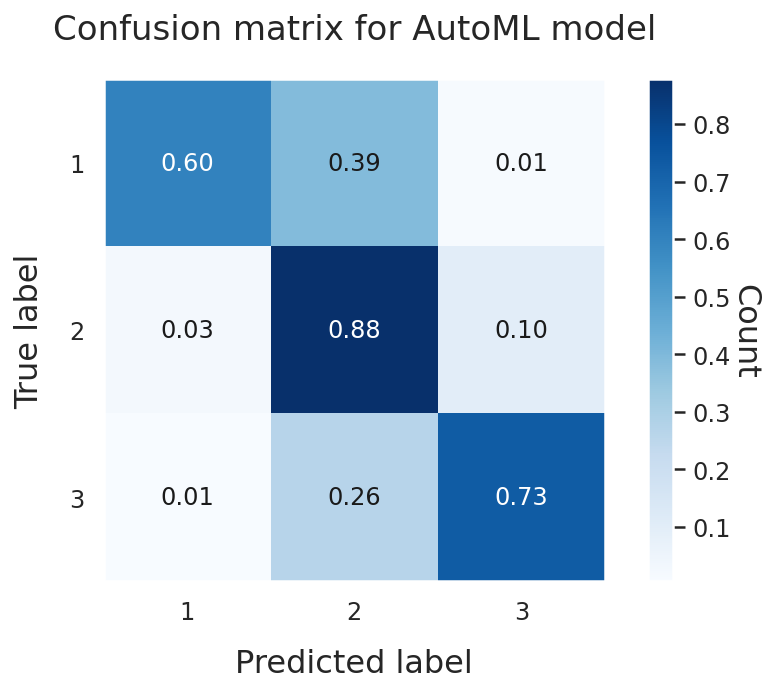

In [ ]:
atom.rf.plot_confusion_matrix(dataset="test", normalize=True, title=f"Confusion matrix for AutoML model", figsize=(8,5)) 

### Compare models results

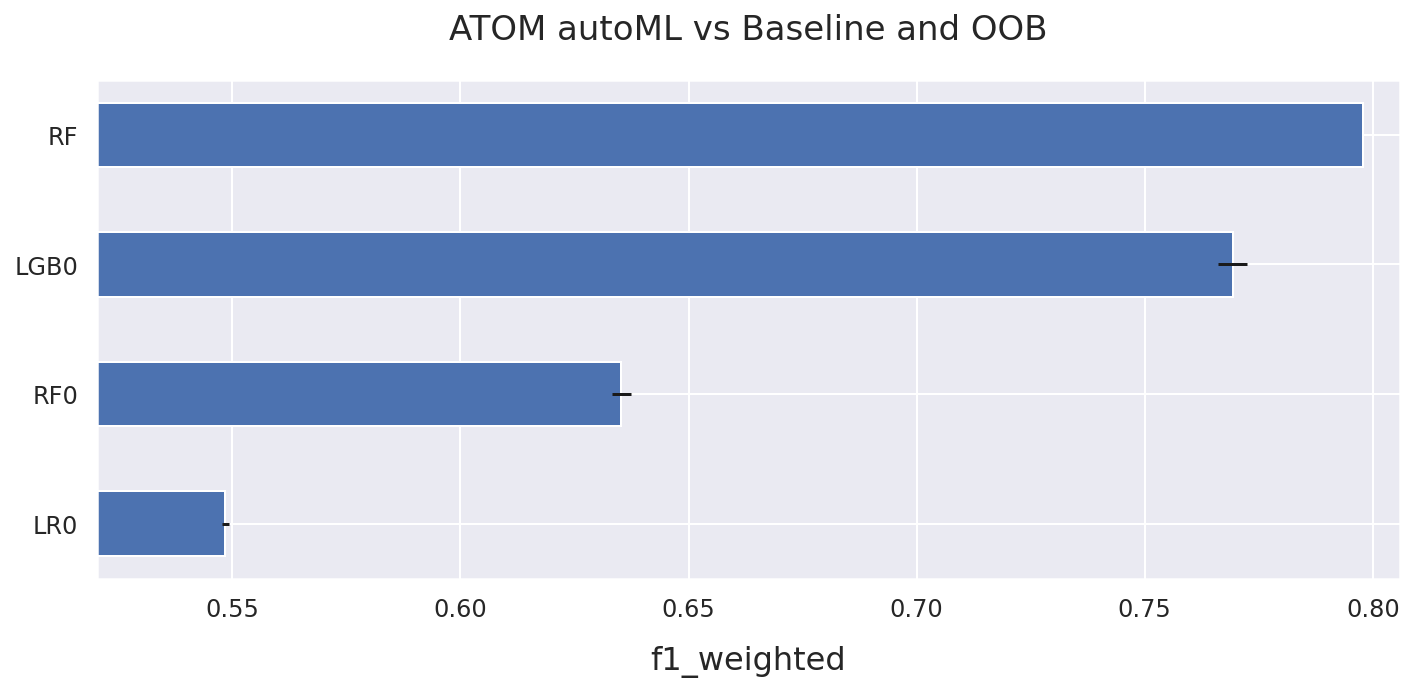

In [ ]:
atom.plot_results(title="ATOM autoML vs Baseline and OOB", figsize=(10,5))

In [ ]:
nice_metric_table(atom.results, metric=metric).style.highlight_max(props='color:orange', axis=0)

#### Make predictions - see pipeline in action

In [ ]:
atom.rf.predict(X)

Imputing missing values...
Applying data cleaning...
Encoding categorical columns...
EntitySet scattered to 8 workers in 3 seconds
Performing feature selection ...
 --> Feature ground_floor_type_x * has_secondary_use_use_police was removed due to low variance. Value 0.0 repeated in 100% of the rows.
 --> Feature has_secondary_use_gov_office * position_j was removed due to low variance. Value 0.0 repeated in 100% of the rows.
 --> Feature has_secondary_use_rental * plan_configuration_n was removed due to low variance. Value 0.0 repeated in 100% of the rows.
 --> Feature has_secondary_use_school * plan_configuration_c was removed due to low variance. Value 0.0 repeated in 100% of the rows.
 --> Feature plan_configuration_f * position_o was removed due to low variance. Value 0.0 repeated in 100% of the rows.
 --> Feature plan_configuration_f * roof_type_x was removed due to low variance. Value 0.0 repeated in 100% of the rows.
 --> Feature plan_configuration_m * position_t was removed due

array([1, 1, 1, ..., 1, 2, 1])

### Conclusion

It took several hours and many TPOT generations to obtain an AutoML model that beats the best H/P-tuned OOB model (LGB in this case) in 3 out of 4 metrics. The winner takes it all, but TPOT is not a miracle as generation of a decent model takes a lot of time.